In [8]:
import numpy as np

probs = np.array([0.6, 0.1, 0.1, 0.1, 0.1])
outcomes = np.array([18, 21, 17, 17, 21])
expected_value = 0.0

# 기댓값(가중 평균) 계산을 반복문으로 구현
for i in range(probs.shape[0]):
    expected_value += probs[i] * outcomes[i]
print(expected_value)

# 두 벡터에 대한 내적 즉, 행렬곱을 수행하면 반복문을 수행하지 않고 기댓값(가중 평균) 계산을 수행할 수 있다
expected_value = probs @ outcomes
print(expected_value)

T = lambda: expected_value + np.random.randn(1)
T()

18.4
18.4


array([19.13162764])

[-10.   -9.6  -9.2  -8.8  -8.4  -8.   -7.6  -7.2  -6.8  -6.4  -6.   -5.6
  -5.2  -4.8  -4.4  -4.   -3.6  -3.2  -2.8  -2.4  -2.   -1.6  -1.2  -0.8
  -0.4   0.    0.4   0.8   1.2   1.6   2.    2.4   2.8   3.2   3.6   4.
   4.4   4.8   5.2   5.6   6.    6.4   6.8   7.2   7.6   8.    8.4   8.8
   9.2   9.6  10. ] (51,)
[0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784]


<BarContainer object of 51 artists>

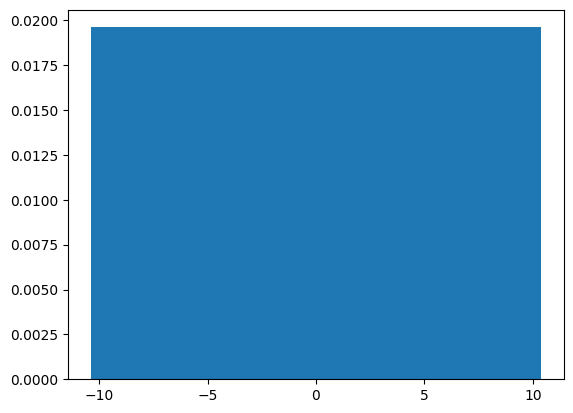

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

vmin, vmax = -10., 10. # 행동 가치 분포에 대한 지지집합(support)의 최대와 최소
nsup = 51 # 지지집합의 크기(지지집합 내 원소의 개수)
support = np.linspace(vmin, vmax, nsup) # [-10.0, 10.0]구간 상에서 양 끝 값을 포함하여 균일하게 형성된(퍼진) 표본들(여기서는 지지집합의 원소이자 행동 가치 분포의 확률 변수 값)이 반환된다
probs = np.ones(nsup)
probs /= probs.sum() # 지지집합에 대응하는 확률을 균일하게 하여, 행동 가치 분포를 균일 분포로 초기화한다
z3 = torch.from_numpy(probs).float() # 에이전트의 행동 공간(action space) 크기가 3(즉, 에이전트가 취할 수 있는 행동이 3개이다)이므로, 3개의 행동 가치 분포가 산출된다
                                     # 분포 Q 함수를 가치 분포 Z라고 표기한다

print(support, support.shape)
print(probs)
plt.bar(support, probs) # bottom 옵션은 막대 그래프 높이의 기준점을 설정한다(bottom=1이라면 높이 1부터 막대 그래프가 그려진다)

In [35]:
# lim = limit, 가치분포 확률 변수 값(지지집합)의 범위를 지정한다
def update_dist(r, probs, lim=(-10.0, 10.0), gamma=0.8):
    '''
    update_dist 함수는 모델이 산출한 예측분포(가치분포)에 대한 목표분포(가치분포)를 구한다
    본래 논문대로 구현한다면 분포 벨먼 방정식에 따라,  목표분포를 구하지만, 책에서는 베이지안 추론 방식으로 목표분포를 구한다
    즉, 예측분포와 목표분포를 각각 사전분포와 사후분포로 간주하여, 예측분포(사전분포)를 주어진 보상을 통해 목표분포(사후분포)로 갱신한다
    주어진 보상으로 사전분포를 사후분포로 갱신하는 방법은 아래와 같다
    1. 보상이 주어지면, 지지집합의 내에서 그 보상과 가장 가까운 원소(행동가치)를 찾는다(이를 위해 지지집합의 최소인 vmin으로부터 r까지의 차이를 계산한다)
    2. 1.에서 발견된 원소를 시작으로 옆의 원소로부터 확률의 일부를 떼어온다(이 과정은 1.에서 발견된 원소를 기준으로 좌측과 우측 방향에 대해 수행된다)
    '''
    
    nsup = probs.shape[0]
    vmin, vmax = lim[0], lim[1]
    dz = (vmax - vmin) / (nsup - 1.0) # dz = delta z, 지지집합 내 원소간 간격
                                      # 지지집합의 크기는 vmax와 vmin을 포함하여 51이고, 그 사이의 간격은 50개이다
                                      # 따라서 dz를 계산할 때는 nsup에 -1을 해주어야 한다
    bj = np.round((r - vmin) / dz) # 주어진 보상 r이 지지집합 내 원소 중 어떤 것과 가장 가까운지 계산한다
    bj = int(np.clip(bj, 0, nsup - 1)) # [0, 50]에 대하여 bj가 0보다 작으면 0으로, 50보다 크면 50으로 설정한다(이 때의 닫힌 구간은 지지집합 내 원소들에 대응하는 인덱스이다)
    m = probs.detach().clone() # probs는 예측분포에 대한 확률 벡터이고, 이를 통해 별도의 목표분포애 대한 확률 벡터를 구하는 것이 목적이므로 clone을 통한 "깊은 복사"를 수행한다

    # 보상에 가장 가까운 지지집합 원소를 시작으로 왼쪽 원소들의 확률 일부를 떼어온다
    j = 1
    for i in range(bj, 1, -1):
        m[i] += np.power(gamma, j) * m[i - 1]
        j += 1

    # 보상에 가장 가까운 지지집합 원소를 시작으로 오른쪽 원소들의 확률 일부를 떼어온다
    j = 1
    for i in range(bj, nsup - 1, 1):
        m[i] += np.power(gamma, j) * m[i + 1]
        j += 1
    m /= m.sum()

    return m

def dist_dqn(x, theta, aspace=3):
    # aspace : action space(행동 공간), 즉, 모델이 어떤 상태에서 취할 수 있는 행동의 가짓수를 가리킨다
    # theta : 모델의 매개변수 벡터
    dim0, dim1, dim2, dim3 = 128, 100, 25, 51
    t1 = dim0 * dim1 # 128 X 100, 첫 번째 계층의 매개변수 벡터(노드 한 개당 100개의 가중치를 갖고, 이것이 128개 존재한다)
    t2 = dim1 * dim2 # 100 X 25, 두 번째 계층의 매개변수 벡터(노드 한 개당 25개의 가중치를 갖고, 이것이 100개 존재한다)
    theta1 = theta[0:t1].reshape(dim0, dim1) # 첫 번째 계층의 매개변수 벡터를 추출한다
    theta2 = theta[t1:t1+t2].reshape(dim1, dim2) # 두 번째 계층의 매개변수 벡터를 추출한다

    # 모델 구성
    l1 = x @ theta1
    l1 = torch.selu(l1)
    l2 = l1 @ theta2
    l2 = torch.selu(l2)
    l3 = [] # 모델은 총 3개의 행동에 대한 가치분포(가치분포)를 산출해야 한다
    
    step = dim2 * dim3 # 25 X 51, 3-n번째 계층의 매개변수 벡터(노드 한 개당 51개의 가중치를 갖고, 이것이 25개 존재한다)
    for i in range(aspace):
        theta5_dim = t1 + t2 + i * step # 매개변수 벡터 내 3-n번째 계층에 해당하는 매개변수들의 범위
        theta5 = theta[theta5_dim:theta5_dim+step].reshape(dim2, dim3) # 3-n번째 계층의 매개변수 벡터를 추출한다 
        l3_ = l2 @ theta5 # 두 번째 계층의 출력을 3-n번째 계층으로 전달하여 처리한다
        l3.append(l3_)
    l3 = torch.nn.functional.softmax(torch.stack(l3, dim=1), dim=2) # 최종적으로 l3는 batch_size X 3 X 51 텐서가 된다

    return l3.squeeze() # squeeze()는 batch_size가 1이 아닌 이상 의미 없는 것으로 보인다

def get_target_dist(dist_batch, action_batch, reward_batch, support, lim=(-10.0, 10.0), gamma=0.8):
    nsup = support.shape[0] # 지지집합의 크기
    vmin, vmax = lim[0], lim[1] # 지지집합의 최대, 최도
    dz = (vmax - vmin) / (nsup - 1) # 지지집합 내 원소 간 간격
    target_dist_batch = dist_batch.detach().clone() # dist_batch로 이에 대응하는 목표분포를 산출하기 위해, detach().clone()으로 원본과 동일하면서 완전히 별개인 텐서를 복사 생성한다

    for i in range(dist_batch.shape[0]):
        dist_full = dist_batch[i] # 특정 하나의 상태에 대한 모델의 출력을 가져온다
        action = int(action_batch[i].item())
        dist = dist_full[action] # 3개의 가치분포 중 목표분포를 생성할 가치분포를 선택한다
        r = reward_batch[i]
        if r != -1: # 보상이 -10 또는 10일 경우
            target_dist = torch.zeros(nsup)
            bj = np.round((r - vmin) / dz)
            bj = int(np.clip(bj, 0, nsup - 1)) # [0, 50]에 대하여 bj가 0보다 작으면 0으로, 50보다 크면 50으로 설정한다
            target_dist[bj] = 1.0 # 보상에 가장 가까운 지지집합 원소만 확률이 1이고 나머지는 0인 퇴화확률분포를 목표분포로 구성한다
        else: # 보상이 -1일 경우
            target_dist = update_dist(r, dist, lim=lim, gamma=gamma)
        target_dist_batch[i, action, :] = target_dist # 목표분포 배치를 생성

    return target_dist_batch

def lossfn(x, y):
    loss = torch.tensor([0.], requires_grad=True)
    # 교차 엔트로피 손실 구현(쿨백-라이블러 발산 함수로부터 유도된다)
    for i in range(x.shape[0]):
        loss_ = -1 * y[i].flatten(start_dim=0) @ torch.log(x[i].flatten(start_dim=0)) # 선택된 행동에 대한 가치분포와 더불어 나머지 가치분포들도 손실값 계산에 사용된다
        loss = loss + loss_

    return loss

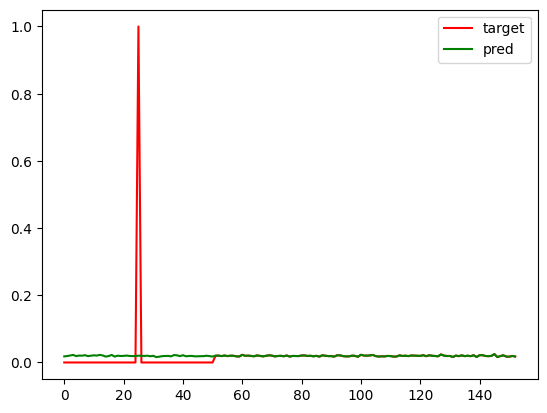

In [45]:
aspace = 3
tot_params = 128 * 100 + 100 * 25 + aspace * 25 * 51
''' 
    아래 2줄의 코드를 실행했을 때만 현재 코드 블럭 바로 밑의 코드 블럭의 역전파가 제대로 수행된다
    그렇지 않고 "theta = torch.randn(tot_params, requires_grad=True) / 10.0"라는 코드를 실행하면
    "The .grad attribute of a Tensor that is not a leaf Tensor is being accessed"라며, 계산 그래프의 말단 노드가 아닌 텐서(not a leaf Tensor)의 grad 속성에 접근했다는 오류가 발생한다
    이러한 오류의 이유는 추측컨데, theta가 "torch.randn(tot_params, requires_grad=True)"한 후 "/ 10.0"라는 2번의 과정을 거쳐서 생성되었기 때문으로 보인다
    즉, 계산 그래프의 입장에서 말단 텐서(leaf Tensor)는 torch.randn(tot_params, requires_grad=True)이며, theta는 해당 말단 텐서에 추가 연산을 통해 생성된 것이 된다
'''
theta = torch.randn(tot_params) / 10.0
theta.requires_grad = True
theta2 = theta.detach().clone() # 목표망

vmin, vmax = -10, 10 # 지지집합의 최소와 최대
gamma = 0.9 # 할인율
lr = 0.00001 # 1e-5, 학습률
update_rate = 75 # 목표망 갱신 주기
support = torch.linspace(-10, 10, 51) # 지지집합 생성

# 실험을 위한 가상의 경험 데이터
state = torch.randn(2, 128) / 10.0
action_batch = torch.tensor([0, 2])
reward_batch = torch.tensor([0, 10])
pred_batch = dist_dqn(state, theta, aspace=aspace) # 2 X 3 X 51 텐서가 반환된다

losses = []
target_dist = get_target_dist(pred_batch, action_batch, reward_batch, support, lim=(vmin, vmax), gamma=gamma) # 2 X 3 X 51 텐서가 반환된다

# 아래의 그래프는 3개의 행동에 대한 가치분포를 일렬로 연결하여 보여주고 있다
plt.plot((target_dist.flatten(start_dim=1)[0].data.numpy()), color="red", label="target")
plt.plot((pred_batch.flatten(start_dim=1)[0].data.numpy()), color="green", label="pred")
plt.legend()

tensor([-0.0019, -0.0015, -0.0115,  ...,  0.0025,  0.0020,  0.0032])
tensor([ 0.0090,  0.0063, -0.0132,  ...,  0.0050,  0.0040,  0.0063])
tensor([ 0.0071,  0.0049, -0.0247,  ...,  0.0076,  0.0060,  0.0095])
tensor([ 0.0052,  0.0034, -0.0363,  ...,  0.0101,  0.0080,  0.0127])
tensor([ 0.0033,  0.0019, -0.0478,  ...,  0.0126,  0.0100,  0.0158])
tensor([ 0.0014,  0.0004, -0.0593,  ...,  0.0151,  0.0120,  0.0190])
tensor([-0.0005, -0.0010, -0.0709,  ...,  0.0176,  0.0140,  0.0222])
tensor([-0.0024, -0.0025, -0.0824,  ...,  0.0202,  0.0160,  0.0254])
tensor([-0.0043, -0.0040, -0.0939,  ...,  0.0227,  0.0180,  0.0285])
tensor([-0.0063, -0.0055, -0.1055,  ...,  0.0252,  0.0201,  0.0317])
tensor([-0.0082, -0.0070, -0.1170,  ...,  0.0277,  0.0221,  0.0349])
tensor([-0.0101, -0.0084, -0.1286,  ...,  0.0303,  0.0241,  0.0381])
tensor([-0.0120, -0.0099, -0.1401,  ...,  0.0328,  0.0261,  0.0412])
tensor([-0.0139, -0.0114, -0.1517,  ...,  0.0353,  0.0281,  0.0444])
tensor([-0.0158, -0.0129, -0.1632,

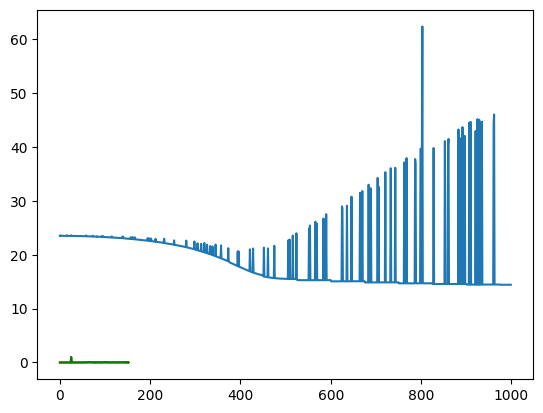

In [46]:
for i in range(1000):
    reward_batch = torch.tensor([0, 8]) + torch.randn(2) / 10.0 # 매 학습 세대마다 보상에 무작위 잡음을 추가하여 과대적합을 방지한다
    pred_batch = dist_dqn(state, theta, aspace=aspace) # 주 신경망
    pred_batch2 = dist_dqn(state, theta2, aspace=aspace) # 목표망
    target_dist = get_target_dist(pred_batch2, action_batch, reward_batch, support, lim=(vmin, vmax), gamma=gamma) # 목표망으로 목표분포를 산출한다

    loss = lossfn(pred_batch, target_dist.detach()) # 역전파로 목표망을 갱신할 것이 아니므로 목표분포에 detach()를 수행한다
    losses.append(loss.item())
    loss.backward()
    with torch.no_grad():
        theta -= lr * theta.grad
    theta.requires_grad = True
    # print(theta.grad)

    if i % update_rate == 0:
        theta2 = theta.detach().clone()

plt.plot((target_dist.flatten(start_dim=1)[0].data.numpy()),color='red',label='target')
plt.plot((pred_batch.flatten(start_dim=1)[0].data.numpy()),color='green',label='pred')
plt.plot(losses)

In [30]:
t = torch.tensor([[[1, 2],
                   [3, 4]],
                  [[5, 6],
                   [7, 8]]])
print(t.shape)
print(torch.flatten(t))
print(torch.flatten(t, start_dim=1))
torch.flatten(t, start_dim=1, end_dim=2)

torch.Size([2, 2, 2])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([[1, 2, 3, 4],
        [5, 6, 7, 8]])


tensor([[1, 2, 3, 4],
        [5, 6, 7, 8]])

In [20]:
a = torch.randn(2, 4)
print(a)

print(torch.stack((a, a), dim=0), torch.stack((a, a), dim=0).shape)
print(torch.stack((a, a), dim=1), torch.stack((a, a), dim=1).shape)
print(torch.stack((a, a), dim=2))

b = torch.randn(10, 51)
torch.stack((b, b, b), dim=1).shape

tensor([[ 0.0476,  0.2269,  1.4417, -1.1455],
        [ 0.1681,  1.9439,  1.1562,  0.2439]])
tensor([[[ 0.0476,  0.2269,  1.4417, -1.1455],
         [ 0.1681,  1.9439,  1.1562,  0.2439]],

        [[ 0.0476,  0.2269,  1.4417, -1.1455],
         [ 0.1681,  1.9439,  1.1562,  0.2439]]]) torch.Size([2, 2, 4])
tensor([[[ 0.0476,  0.2269,  1.4417, -1.1455],
         [ 0.0476,  0.2269,  1.4417, -1.1455]],

        [[ 0.1681,  1.9439,  1.1562,  0.2439],
         [ 0.1681,  1.9439,  1.1562,  0.2439]]]) torch.Size([2, 2, 4])
tensor([[[ 0.0476,  0.0476],
         [ 0.2269,  0.2269],
         [ 1.4417,  1.4417],
         [-1.1455, -1.1455]],

        [[ 0.1681,  0.1681],
         [ 1.9439,  1.9439],
         [ 1.1562,  1.1562],
         [ 0.2439,  0.2439]]])


torch.Size([10, 3, 51])

In [26]:
c = torch.randn((2,))
c[0].item()

-0.6190512776374817

<BarContainer object of 51 artists>

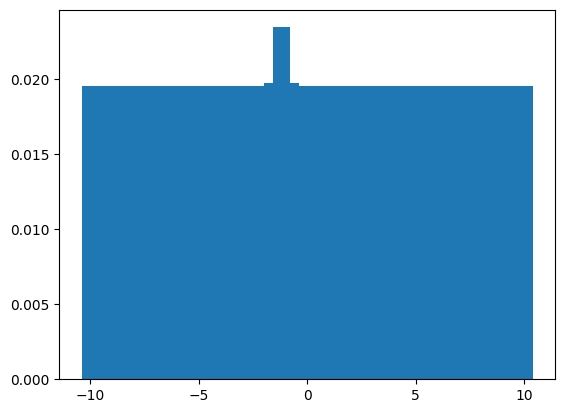

In [10]:
## update_dist 함수 실험 1 ##

ob_rewards = -1
Z = update_dist(ob_rewards, torch.from_numpy(probs).float(), lim=(vmin, vmax), gamma=0.1)
plt.bar(support,Z)

<BarContainer object of 51 artists>

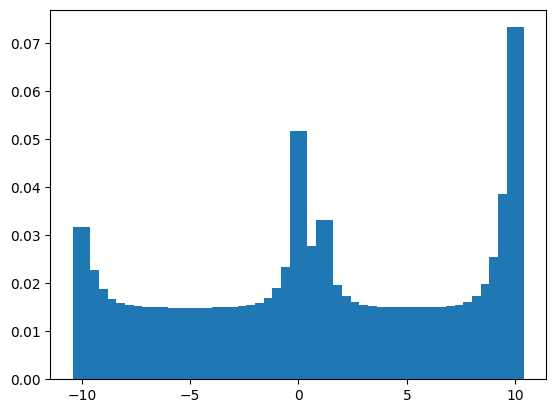

In [11]:
## update_dist 함수 실험 2 ##

ob_rewards2 = [10, 10, 10, 0, 1, 0, -10, -10, 10, 10]
Z2 = torch.from_numpy(probs).float()
for i in range(len(ob_reward2)):
    Z2 = update_dist(ob_rewards2[i], Z2, lim=(vmin, vmax), gamma=0.5)
plt.bar(support, Z2)

<BarContainer object of 51 artists>

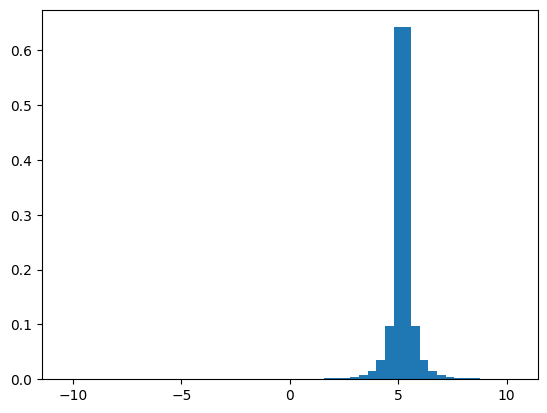

In [12]:
## update_dist 함수 실험 3 ##

ob_rewards3 = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Z3 = torch.from_numpy(probs).float()
for i in range(len(ob_rewards3)):
    Z3 = update_dist(ob_rewards3[i], Z3, lim=(vmin, vmax), gamma=0.7)
plt.bar(support, Z3)